In [1]:
import os
import joblib
import pandas as pd
import matplotlib.pyplot as plt
from rdkit.Chem import Lipinski, Crippen, rdMolDescriptors
from rdkit import Chem
from collections import Counter
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error
import numpy as np
from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline

import seaborn
import scipy
from sklearn.preprocessing import StandardScaler

import warnings

warnings.filterwarnings('ignore')

In [2]:
# loading data
data = pd.read_csv("train.csv")
X, y, smiles = data.drop(["Tm","id","SMILES"], axis=1), data["Tm"], data["SMILES"]

In [3]:
X

,Group 1,Group 2,Group 3,Group 4,Group 5,Group 6,Group 7,Group 8,Group 9,Group 10,...,Group 415,Group 416,Group 417,Group 418,Group 419,Group 420,Group 421,Group 422,Group 423,Group 424
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2657,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2658,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2659,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2660,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
smiles

0             FC1=C(F)C(F)(F)C1(F)F
1       c1ccc2c(c1)ccc3Nc4ccccc4c23
2               CCN1C(C)=Nc2ccccc12
3                        CC#CC(=O)O
4                         CCCCC(S)C
                   ...             
2657                         ClCCBr
2658                 N#CC(Cl)(Cl)Cl
2659             Cc1ccc2c(C)cccc2c1
2660          CCC(=O)c1ccc2ccccc2c1
2661              Brc1ccc(cc1)N(C)C
Name: SMILES, Length: 2662, dtype: object

In [5]:
def extract_features(smiles: str):
    """
    Extracting chemical features using Chem library
    """
    
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    return {
        # Composition & mass
        "ExactMolWt": rdMolDescriptors.CalcExactMolWt(mol),

        # Physicochemical descriptors
        "LogP": Crippen.MolLogP(mol),
        "TPSA": rdMolDescriptors.CalcTPSA(mol),
        "Fraction_CSP3": rdMolDescriptors.CalcFractionCSP3(mol),
        "Formal_Charge": sum(atom.GetFormalCharge() for atom in mol.GetAtoms()),

        # Topology
        "Num_Rings": rdMolDescriptors.CalcNumRings(mol),
        "Num_Aromatic_Rings": rdMolDescriptors.CalcNumAromaticRings(mol),
        "Rotatable_Bonds": Lipinski.NumRotatableBonds(mol),

        # Atomic composition
        "Heavy_Atom_Count": rdMolDescriptors.CalcNumHeavyAtoms(mol),
        "Num_Heteroatoms": rdMolDescriptors.CalcNumHeteroatoms(mol),
        "Num_StereoCenters": rdMolDescriptors.CalcNumAtomStereoCenters(mol),

        # H-bonding / Drug-likeness features
        "HBA": Lipinski.NumHAcceptors(mol),
        "HBD": Lipinski.NumHDonors(mol),
    }

features_list = [extract_features(s) for s in smiles]
df_custom_features = pd.DataFrame([f for f in features_list if f is not None])
print(df_custom_features)

      ExactMolWt     LogP   TPSA  Fraction_CSP3  Formal_Charge  Num_Rings  \
0     161.990419  2.42120   0.00       0.500000              0          1   
1     217.089149  4.47430  15.79       0.000000              0          4   
2     160.100048  2.36462  17.82       0.300000              0          2   
3      84.021129  0.09430  37.30       0.250000              0          0   
4     118.081621  2.49490   0.00       1.000000              0          0   
...          ...      ...    ...            ...            ...        ...   
2657  141.918490  1.62010   0.00       1.000000              0          0   
2658  142.909632  1.88018  23.79       0.500000              0          0   
2659  156.093900  3.45664   0.00       0.166667              0          2   
2660  184.088815  3.43250  17.07       0.153846              0          2   
2661  198.999661  2.51510   3.24       0.250000              0          1   

      Num_Aromatic_Rings  Rotatable_Bonds  Heavy_Atom_Count  Num_Heteroatom

In [6]:
def element_counts(smiles: str):
    """
    Counting the number of chemical elements
    """
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    # List of element symbols in the molecule
    elements = [atom.GetSymbol() for atom in mol.GetAtoms()]
    return dict(Counter(elements))

counts = []
for s in smiles:
    counts.append(element_counts(s))
    
df_chemical_elements = pd.DataFrame(counts).fillna(0)

In [7]:
# combining features together

df = pd.concat([X, df_custom_features], axis=1)
df = pd.concat([df, df_chemical_elements], axis=1)

df.head()

,Group 1,Group 2,Group 3,Group 4,Group 5,Group 6,Group 7,Group 8,Group 9,Group 10,...,F,C,N,O,S,Cl,Br,P,Si,I
0,0,0,0,0,0,0,0,0,0,0,...,6.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,0,0,0,0,0,0,0,0,...,0.0,16.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,1,0,0,0,0,0,0,0,0,...,0.0,10.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,0,0,0,0,0,0,0,0,0,...,0.0,4.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2,3,0,0,0,0,0,0,0,0,...,0.0,6.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


EDA

In [8]:
# dataframe size
df.shape

(2662, 447)

In [9]:
# are there any missing values?
df.isna().any().any()

np.False_

In [36]:
df.describe()

,Group 1,Group 2,Group 3,Group 4,Group 5,Group 6,Group 7,Group 8,Group 9,Group 10,...,F,C,N,O,S,Cl,Br,P,Si,I
count,2662.000000,2662.000000,2662.000000,2662.000000,2662.000000,2662.000000,2662.000000,2662.000000,2662.000000,2662.000000,...,2662.000000,2662.000000,2662.000000,2662.000000,2662.000000,2662.000000,2662.000000,2662.000000,2662.000000,2662.000000
mean,1.020661,1.582269,0.114951,0.036439,0.036814,0.022915,0.013524,0.010143,0.007137,0.000751,...,0.216003,8.181443,0.348234,0.941022,0.055973,0.317431,0.096168,0.008640,0.019159,0.017656
std,1.353640,3.738416,0.425964,0.208307,0.205516,0.164037,0.118732,0.117480,0.092695,0.027405,...,1.160025,4.600188,0.648238,1.186758,0.259114,0.901536,0.452718,0.092567,0.243690,0.147852
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,8.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,10.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,16.000000,42.000000,6.000000,3.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,...,18.000000,51.000000,6.000000,9.000000,3.000000,8.000000,10.000000,1.000000,7.000000,2.000000


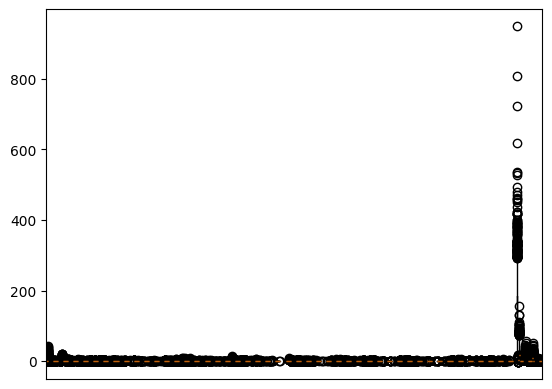

In [39]:
plt.boxplot(df)
plt.xticks([])
plt.show()

In [46]:
indexes = np.argwhere(df.describe() > 800)
indexes = indexes[indexes[:, 0] != 0]
indexes

array([[  7, 424]])

In [45]:
df.describe().iloc[:, 424]

count    2662.000000
mean      157.647182
std        69.088762
min        31.042199
25%       114.104465
50%       145.939152
75%       184.984011
max       949.178286
Name: ExactMolWt, dtype: float64

In [10]:
# standarise
df_scaled = pd.DataFrame(StandardScaler().fit_transform(df), columns=df.columns)

In [11]:
# indexes of features with nearly constant values
indexes_of_constant_features = np.argwhere(df_scaled.std() < 1e-12)

len(indexes_of_constant_features)

88

In [12]:
df_no_constant = df.drop(columns=[df_scaled.columns[i].item() for i in indexes_of_constant_features])

In [13]:
# calculate correlation
corr = df_no_constant.corr()

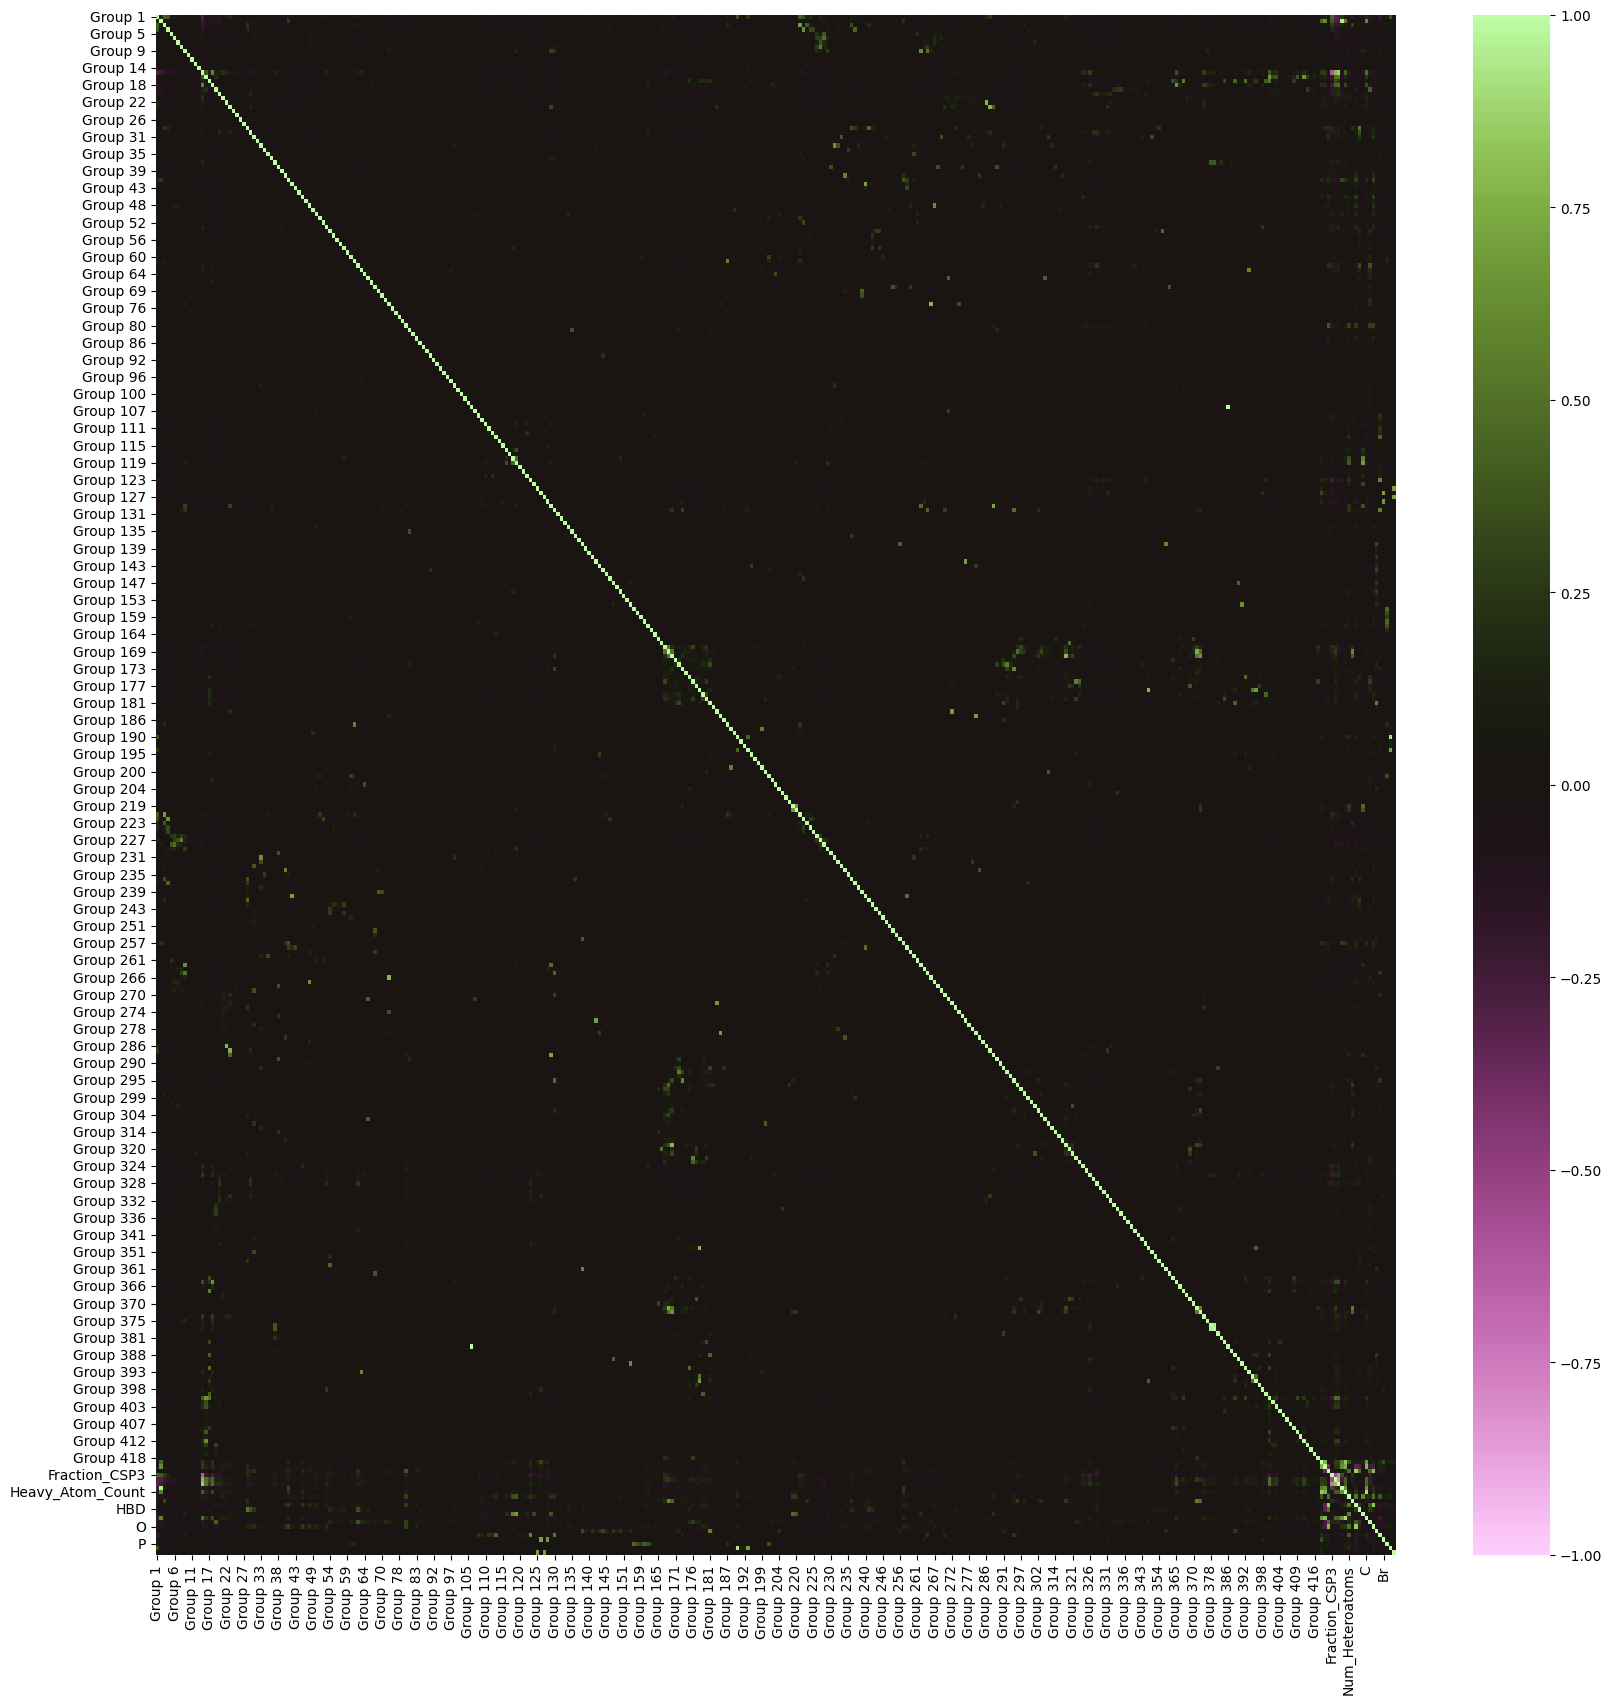

In [14]:
# and visualise it
plt.subplots(figsize=(20, 20))
seaborn.heatmap(corr, vmin=-1, vmax=1, cmap="vanimo")
plt.show()

In [15]:
def get_correlated_features(corr, theta):
    """ returns pairs of linearly correlated features at theta threshold """
    
    corr = np.abs(corr)
    
    # select only those exceeding threshold
    indexes = np.argwhere(corr > theta)

    # since correlation matrix is symmetric, ignore repeating values
    indexes = indexes[indexes[:, 0] < indexes[:, 1]]

    return indexes

In [16]:
def num_of_correlated(corr, N):
    """ Returnes list of numbers of identified linearly correlated features for given threshold across different values of thresholds """
    
    return [len(get_correlated_features(corr, theta)) for theta in np.linspace(0, 1, N)]

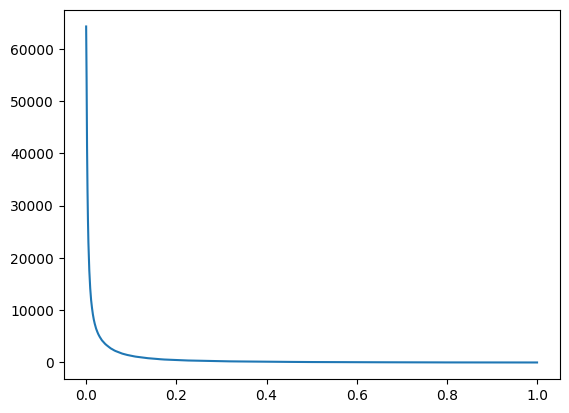

In [17]:
# visualise
plt.plot(np.linspace(0, 1, 1000), num_of_correlated(corr, 1000))
plt.show()

In [18]:
# correlated features at threshold 80%
indexes = get_correlated_features(corr, 0.8)

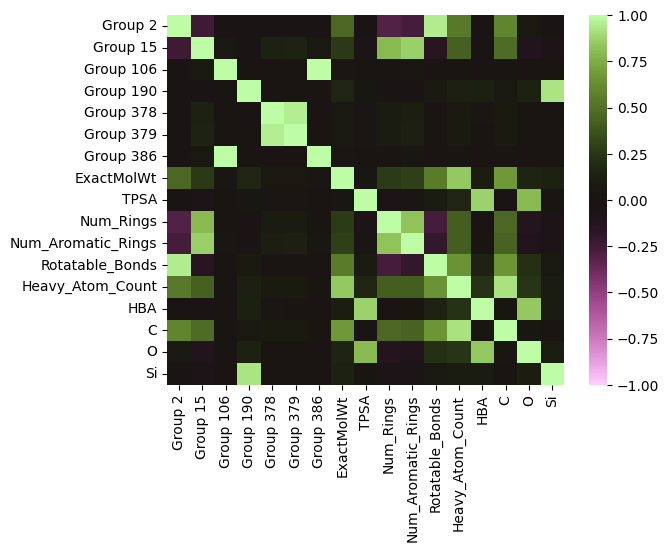

In [19]:
# zoomed heatmap of selected correlated features
seaborn.heatmap(df_no_constant.iloc[:, np.unique(indexes.flatten())].corr(), vmin=-1, vmax=1, cmap="vanimo")
plt.show()

In [20]:
# sample correlation values
for (col1, col2) in get_correlated_features(corr, 0.8):
    print(f"{df_no_constant.columns[col1]:20} and {df_no_constant.columns[col2]:20} = {scipy.stats.pearsonr(df_no_constant.iloc[:, col1], df_no_constant.iloc[:, col2])[0]:.5f}")

Group 2              and Rotatable_Bonds      = 0.94829
Group 15             and Num_Aromatic_Rings   = 0.86701
Group 106            and Group 386            = 1.00000
Group 190            and Si                   = 0.92592
Group 378            and Group 379            = 0.95725
ExactMolWt           and Heavy_Atom_Count     = 0.83733
TPSA                 and HBA                  = 0.87182
Num_Rings            and Num_Aromatic_Rings   = 0.82563
Heavy_Atom_Count     and C                    = 0.91947
HBA                  and O                    = 0.83602


In [21]:
# evaluating what features to remove due to correlation
cols_to_drop = []
for (col1, col2) in get_correlated_features(corr, 0.8):
    if not (col1 in cols_to_drop or col2 in cols_to_drop):
        cols_to_drop.append(col1)

In [22]:
# without correlated features
df_no_correlated = df_no_constant.drop(columns=[df_no_constant.columns[i] for i in cols_to_drop])

In [23]:
# function to calculate mutual information
def mi_matrix(X):
    mi = pd.DataFrame({col: mutual_info_regression(X.drop(columns=col), X[col]) for col in X.columns})

    def extract_col(df, col):
        return pd.DataFrame(df[col]).set_index(df.columns.drop(col)).to_dict()
        
    rows = []
    for col in mi.columns:
        rows.append(extract_col(mi, col)[col])

    df_mi = pd.DataFrame(rows)
    df_mi = pd.concat((df_mi.iloc[:, -1], df_mi.iloc[:, :-1]), axis=1)
    df_mi = df_mi.set_index(df_mi.columns)

    return df_mi

In [24]:
df_mi = mi_matrix(df_no_correlated)

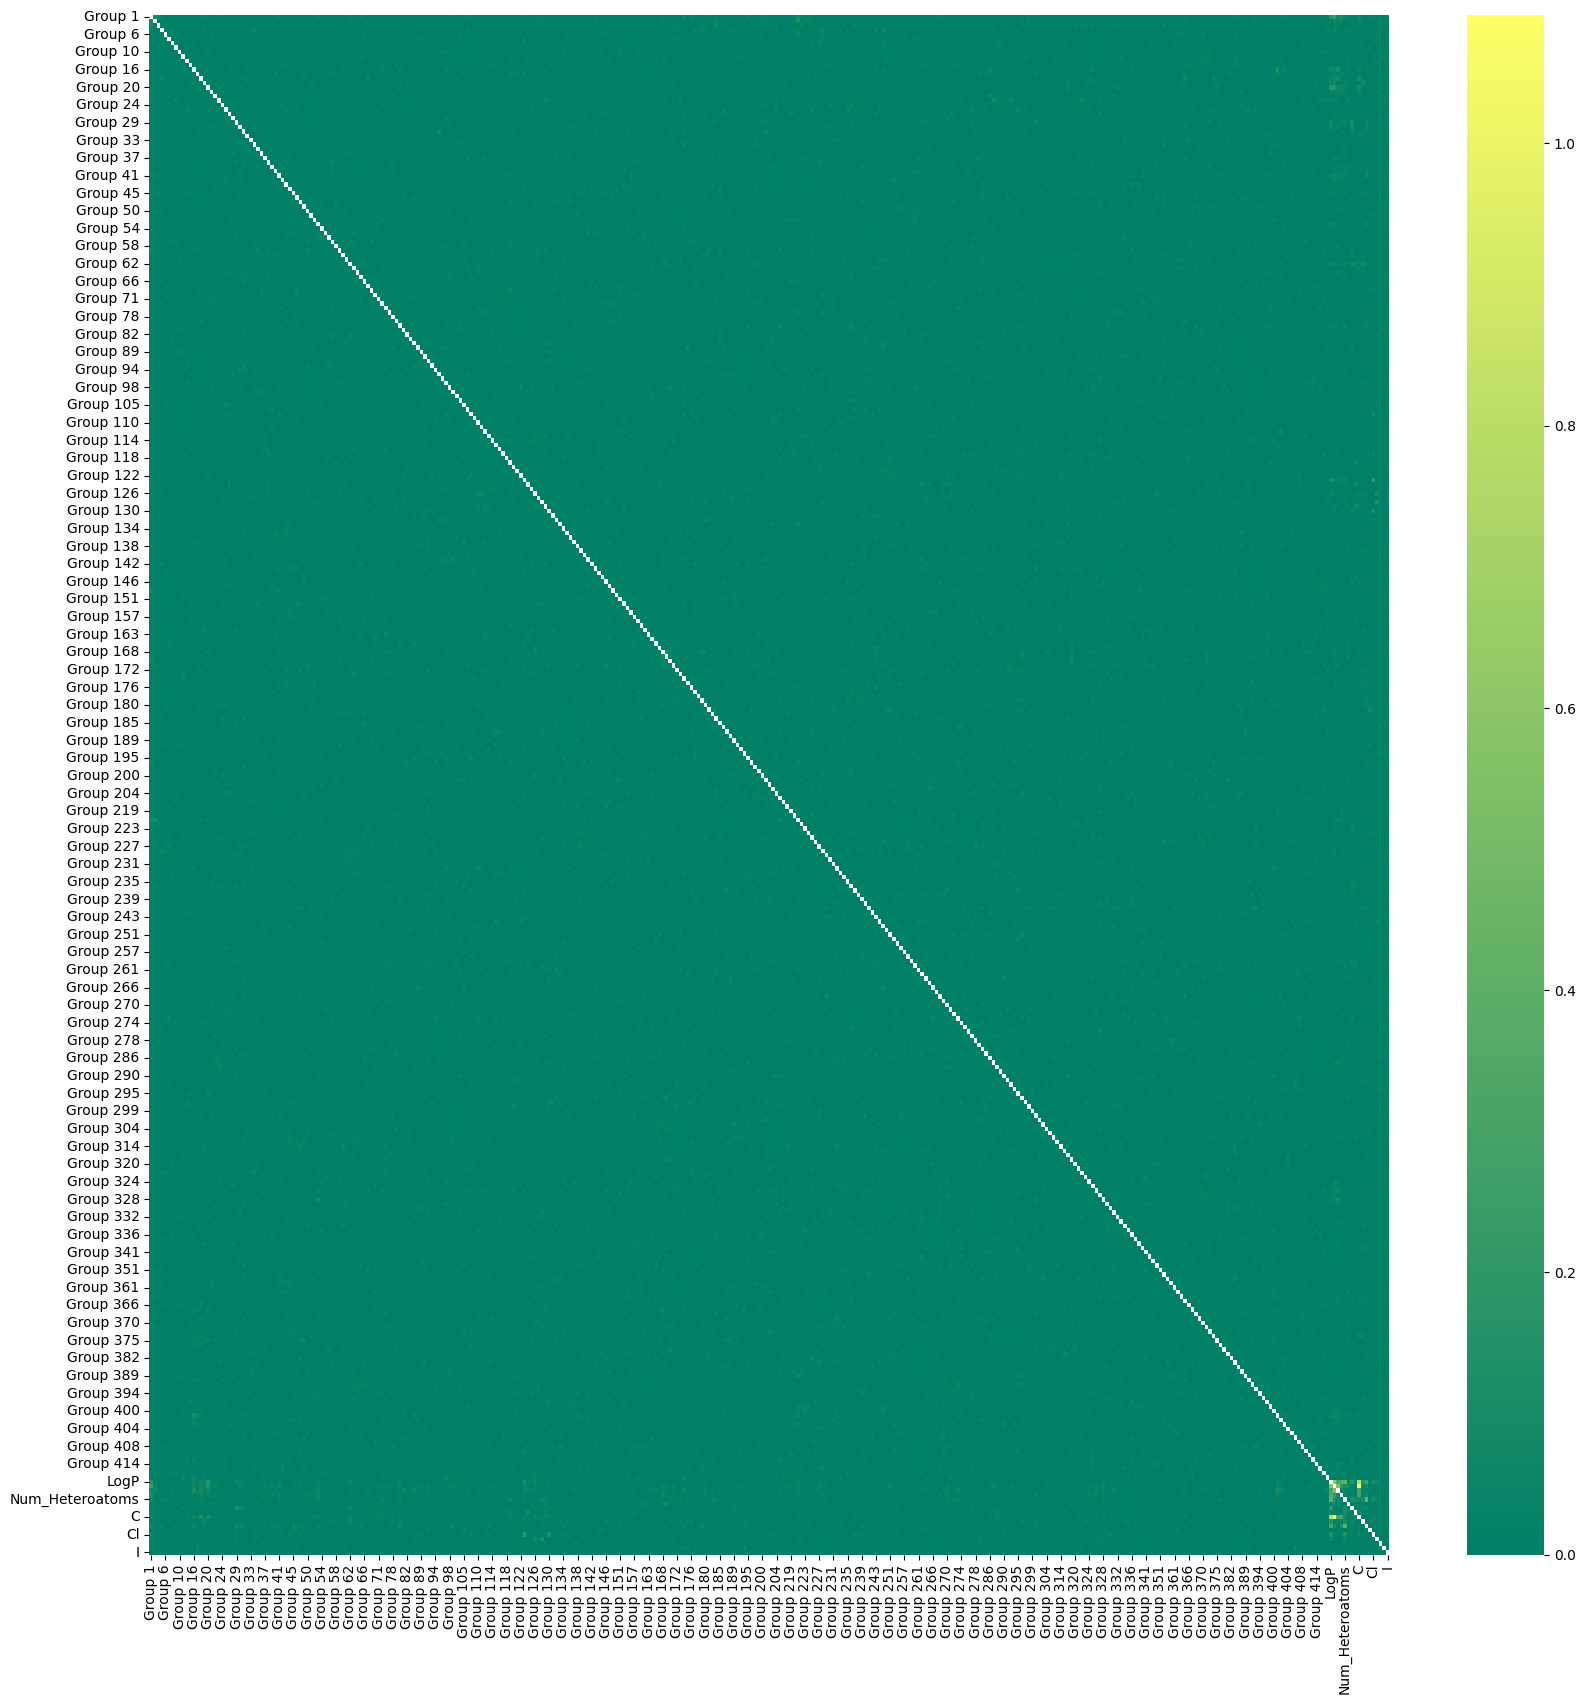

In [25]:
plt.subplots(figsize=(20, 20))
seaborn.heatmap(df_mi, vmin=0, cmap="summer")
plt.show()

### Tasks:
1. Split data
2. Standardize
3. Feature selection (MI / RF-FI)
4. Modelling with hyper-parameter tuning

In [ ]:
# splitting data

X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

In [ ]:
X_train

In [ ]:
# normalization

# we have mainly counting features, they are non-negative, so min-max scaling may be the best option

feature_scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = feature_scaler.fit_transform(X_train)
X_test_scaled = feature_scaler.transform(X_test)

y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1))

os.makedirs("scalers", exist_ok=True)
joblib.dump(feature_scaler, "scalers/feature_scaler.pkl")
joblib.dump(y_scaler, "scalers/y_scaler.pkl")

## Dimensionality reduction/feature selection
#### Important note: the 'optimal' number of features was selected based on results on the test set, it would be better to extract additional validation set for this purpose or perform cross-validation

### PCA approach

In [ ]:
# dimensionality reduction

n_feature_list = []
mae_list = []

for v in np.linspace(0.1, 0.9, 9):
    pca = PCA(n_components=v)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    
    model = RandomForestRegressor(criterion='absolute_error', n_estimators=100, random_state=42, n_jobs=-1) # optimizing MAE directly
    model.fit(X_train_pca, y_train_scaled.ravel())
    
    y_pred = model.predict(X_test_pca)
    y_pred_rescaled = y_scaler.inverse_transform(y_pred.reshape(-1, 1))
    print(f"Preserved variance: {v:.2f}, n_features: {X_train_pca.shape[1]}, Test MAE: {mean_absolute_error(y_test, y_pred_rescaled):.2f}")
    
    n_feature_list.append(X_train_pca.shape[1])
    mae_list.append(mean_absolute_error(y_test, y_pred_rescaled))
    
# MAE around 35

In [ ]:
plt.plot(n_feature_list, mae_list)
plt.xlabel("number of features")
plt.ylabel("Test MAE")
plt.show()

### Mutual information

In [ ]:
mi_scores = mutual_info_regression(X_train_scaled, y_train_scaled.ravel(), random_state=42)
mi_scores = pd.Series(mi_scores) #, index=X_train.columns)
mi_scores = mi_scores.sort_values(ascending=False)

print(mi_scores)

In [ ]:
mi_scores.plot.bar(figsize=(12,4), title="Mutual Information Feature Scores")

In [ ]:
n_feature_list = []
mae_list = []

for p in np.arange(10, len(X_train.columns), step=10):
    top_features = mi_scores.head(p).index # selecting top p features according to MI
    X_train_selected = X_train_scaled[:, top_features]
    X_test_selected = X_test_scaled[:, top_features]
    
    model = RandomForestRegressor(criterion='absolute_error', n_estimators=100, random_state=42, n_jobs=-1) # optimizing MAE directly
    model.fit(X_train_selected, y_train_scaled.ravel())
    
    y_pred = model.predict(X_test_selected)
    y_pred_rescaled = y_scaler.inverse_transform(y_pred.reshape(-1, 1))
    print(f"n_features: {p}, Test MAE: {mean_absolute_error(y_test, y_pred_rescaled):.2f}")
    
    n_feature_list.append(p)
    mae_list.append(mean_absolute_error(y_test, y_pred_rescaled))
    
# MAE around 33 - performs better than PCA - we may select an elbow point

In [ ]:
plt.plot(n_feature_list, mae_list)
plt.xlabel("number of features")
plt.ylabel("Test MAE")
plt.show()

# about 150 features looks reasonable

### Correlation

In [ ]:
corr_scores = X_train.apply(lambda col: col.corr(y_train), axis=0).abs() # counting it on X_train_scaled should give the same results
corr_scores = corr_scores.sort_values(ascending=False)

n_feature_list_corr = []
mae_list_corr = []

for p in np.arange(10, len(X_train.columns), 10):
    top_features_corr = corr_scores.head(p).index  # select top p features by correlation
    
    X_train_selected = pd.DataFrame(X_train_scaled, columns=X_train.columns)[top_features_corr].values
    X_test_selected  = pd.DataFrame(X_test_scaled, columns=X_train.columns)[top_features_corr].values

    model = RandomForestRegressor(
        criterion='absolute_error',
        n_estimators=100,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train_selected, y_train_scaled.ravel())

    y_pred = model.predict(X_test_selected)
    y_pred_rescaled = y_scaler.inverse_transform(y_pred.reshape(-1, 1))

    mae = mean_absolute_error(y_test, y_pred_rescaled)
    print(f"[Corr] n_features: {p}, Test MAE: {mae:.2f}")

    n_feature_list_corr.append(p)
    mae_list_corr.append(mae)

# similar results to MI, maybe slightly better
# MAE around 33

In [ ]:
plt.plot(n_feature_list_corr, mae_list_corr)
plt.xlabel("number of features")
plt.ylabel("Test MAE")
plt.show()

# top 40, 160 features is good -> let's take 160 (similar to MI results)

## Modelling

#### At this step we look for the best model and hyperparameters, after finding it, we may potentially train the final model on the full set

In [ ]:
# we take top 160 features based on correlation

N_FEATURES = 160
top_features_corr = corr_scores.head(N_FEATURES).index
X_train_selected = pd.DataFrame(X_train_scaled, columns=X_train.columns)[top_features_corr].values
X_test_selected  = pd.DataFrame(X_test_scaled, columns=X_train.columns)[top_features_corr].values

In [ ]:
# saving features
os.makedirs("features", exist_ok=True)
joblib.dump(top_features_corr, "features/selected_features.pkl")
joblib.dump(X_train.columns, "features/all_features.pkl")

In [ ]:
# defining models and their hyperparameter grids

models = {
    "RandomForest": RandomForestRegressor(random_state=42, n_jobs=-1),
    "GradientBoosting": GradientBoostingRegressor(random_state=42),
    "SVR": SVR(),
    "Ridge": Ridge(),
    "KNN": KNeighborsRegressor()
}

param_grids = {
    "RandomForest": {
        "model__n_estimators": [100, 200, 300, 500],
        "model__max_depth": [None, 10, 20, 30],
        "model__min_samples_split": [2, 5, 10],
        "model__min_samples_leaf": [1, 2, 4],
        "model__max_features": ["auto", "sqrt", "log2"]
    },
    "GradientBoosting": {
        "model__n_estimators": [100, 200, 300],
        "model__learning_rate": [0.01, 0.05, 0.1, 0.2],
        "model__max_depth": [3, 5, 7],
        "model__min_samples_split": [2, 5, 10],
        "model__min_samples_leaf": [1, 2, 4],
        "model__subsample": [0.7, 0.85, 1.0]
    },
    "SVR": {
        "model__C": [0.1, 1, 10, 50],
        "model__gamma": ["scale", "auto", 0.01, 0.1],
        "model__kernel": ["rbf", "poly", "sigmoid"],
        "model__degree": [2, 3, 4]
    },
    "Ridge": {
        "model__alpha": [0.01, 0.1, 1, 10, 50, 100],
        "model__solver": ["auto", "svd", "cholesky", "lsqr", "sparse_cg"]
    },
    "KNN": {
        "model__n_neighbors": [3, 5, 7, 9, 11],
        "model__weights": ["uniform", "distance"],
        "model__p": [1, 2]
    }
}

In [ ]:
# comparing models

os.makedirs("models", exist_ok=True)

results = []

for name, model in models.items():
    print(f"Training {name}...")
    
    pipeline = Pipeline([
        ("model", model)
    ])
    
    grid = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grids[name],
        scoring='neg_mean_absolute_error',
        cv=5,
        n_jobs=-1
    )
    
    grid.fit(X_train_selected, y_train_scaled.ravel())
    
    # Predict and rescale target
    y_pred_scaled = grid.predict(X_test_selected)
    y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1,1))
    
    mae = mean_absolute_error(y_test, y_pred)
    
    print(f"{name} best params: {grid.best_params_}")
    print(f"{name} Test MAE: {mae:.3f}\n")
    
    # Save model
    joblib.dump(grid.best_estimator_, f"models/{name}_best_model.pkl")
    
    # Store results
    results.append({
        "model": name,
        "mae": mae,
        "best_params": grid.best_params_
    })

results_df = pd.DataFrame(results)
results_df.to_csv("model_comparison.csv", index=False)

In [ ]:
results_df
# gradient boosting gives the best results - MAE about 30

## Pipeline for preparing new data and prediction

In [ ]:
# perform feature extraction using the functions above
# normalize data using saved scalers
# make sure that the features of incoming data are the same as training features, so we should load selected features from 'features' directory
# load model (maybe we want to train the final model on the full set?)
# perform prediction (and rescale results)
# return results and save them in a submission file (format specified at https://www.kaggle.com/competitions/melting-point/data)

## EDA

In [ ]:
y

In [ ]:
df_corr = pd.concat([X, y], axis=1).select_dtypes(include='number')

correlations = df_corr.corr(numeric_only=True)['Tm'].drop('Tm')

abs_corr = correlations.abs().sort_values(ascending=False)

top50 = abs_corr.head(50)

print("Top 50 variables most correlated with the target:")
print(top50)


plt.figure(figsize=(12, 6))
plt.bar(range(len(abs_corr)), abs_corr.values, color='steelblue', edgecolor='black')
plt.title("Correlation plot")
plt.ylabel("|r|")
plt.xlabel("Top variables sorted by |r|")

step = 10
xticks_idx = range(0, len(abs_corr), step)
plt.xticks(xticks_idx, xticks_idx, rotation=90, ha='right')
plt.xlim(0, 420)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
top50.plot(kind='bar', color='orange', edgecolor='black')
plt.title("Top 50 most correlated variables")
plt.ylabel("|r|")
plt.xlabel("variables")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
texts = smiles.tolist()
# Compute string lengths
lengths = [len(t) for t in texts]

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(lengths, bins=range(min(lengths), max(lengths) + 2), color='skyblue', edgecolor='black', rwidth=0.9)

plt.title("Distribution of String Lengths")
plt.xlabel("String Length")
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


Cut to 50 is reasonable

In [ ]:
X[top50.index]

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import numpy as np

# Evaluate 5-fold CV MAE for different top feature counts
for n in range(10,420,10):
    top_features = abs_corr.head(n).index

    model = LinearRegression()
    
    # 5-fold cross-validation, scoring='neg_mean_absolute_error'
    scores = cross_val_score(model, X[top_features], y, cv=10, scoring='neg_mean_absolute_error')
    
    mae_mean = -scores.mean()  # negate because scores are negative
    mae_std = scores.std()
    
    print(f"Top {n} features → 5-fold CV MAE: {mae_mean:.4f} ± {mae_std:.4f}")


In [ ]:

# Assuming you already have:
# y_test (true values)
# y_pred (predicted values)
y_test = y
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, color='steelblue', alpha=0.6, edgecolor='k')

plt.title("Actual vs Predicted Values")
plt.xlabel("Actual (True) Values")
plt.ylabel("Predicted Values")
plt.tight_layout()
plt.show()


In [ ]:
residuals = y_test - y_pred

plt.figure(figsize=(7,5))
plt.scatter(y_test, residuals, color='royalblue', alpha=0.6, edgecolor='k')
#plt.axhline(y=0, color='red', linestyle='--', linewidth=2)

plt.title("Residuals vs Actual Values")
plt.xlabel("Actual (True) Values")
plt.ylabel("Residuals (y_true - y_pred)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()